In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted

In [2]:
# function to wrangle the data from any csv file passed into it
# the focus here is to have a dataframe focused on apartments in Capital Federal that costs less than 400,000 USD
def wrangle(filepath):
    df = pd.read_csv(filepath, encoding='latin-1')
    
#     filter subset data for Capital Federal
    df_capital = df['place_with_parent_names'].str.contains('Capital Federal')
    
#     filter for property type that are apartment
    df_apartment = df['property_type'] == 'apartment'
    
#     filter for price that is less than 400,000 usd
    df_price = df['price_aprox_usd'] < 400_000
    df = df[df_capital & df_apartment & df_price]
    
#     accounting for the eliminated outliers in the data set for surface area covered
    low,high = df['surface_covered_in_m2'].quantile([0.1, 0.9])
    df_masked_area = df['surface_covered_in_m2'].between(low, high)
    df = df[df_masked_area]
    
    
    
    return df

In [3]:
df = wrangle('data/buenos-aires-real-estate-1.csv')
print('Shape:', df.shape)
df.head()

Shape: (1343, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,sell,apartment,|Argentina|Capital Federal|Constitución|,"-34.6252219,-58.3823825",57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...
41,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...


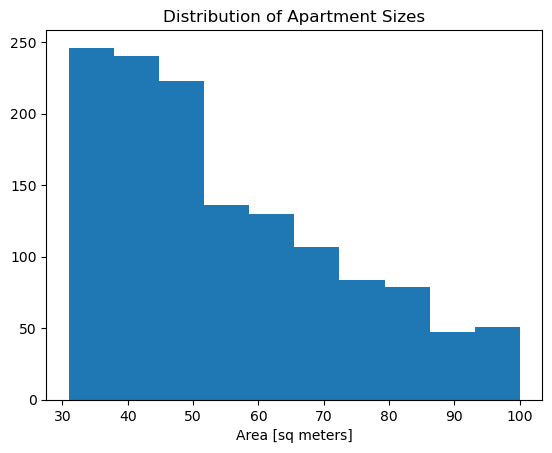

In [4]:
# Exploring the wrangled data
# using a histogram to check the distribution of the surface area of the apartments
plt.hist(df['surface_covered_in_m2'])
plt.xlabel('Area [sq meters]')
plt.title('Distribution of Apartment Sizes');

In [5]:
# This histogram suggests that the dataset has some outliers
# having a look at the statisticts of the surface area data
df.describe()['surface_covered_in_m2']

count    1343.000000
mean       55.076694
std        18.160427
min        31.000000
25%        40.000000
50%        50.000000
75%        68.500000
max       100.000000
Name: surface_covered_in_m2, dtype: float64

In [6]:
# eliminating the bottom and top 10 percent form the df
low,high = df['surface_covered_in_m2'].quantile([0.1, 0.9])
df_masked_area = df['surface_covered_in_m2'].between(low, high)
df_masked_area

4       True
9       True
29      True
40      True
41      True
        ... 
8589    True
8590    True
8593    True
8601    True
8604    True
Name: surface_covered_in_m2, Length: 1343, dtype: bool

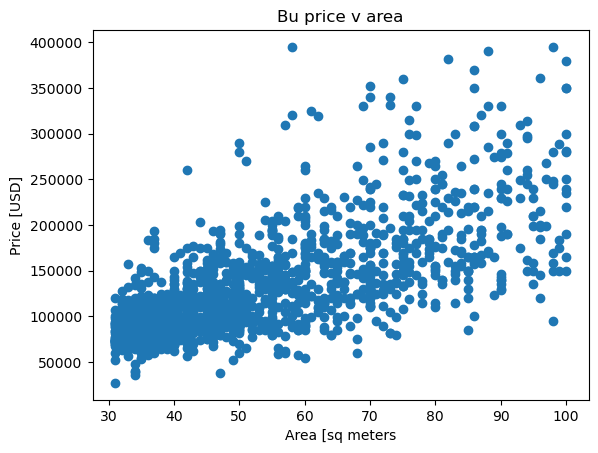

In [7]:
# using a scatter plot to show the distribution of dataset with egards to price and area
plt.scatter(x=df['surface_covered_in_m2'], y=df['price_aprox_usd'])
plt.xlabel('Area [sq meters')
plt.ylabel('Price [USD]')
plt.title('Bu price v area');

In [8]:
# checking the pearson correlation coefficient
p_corr_capital = df['surface_covered_in_m2'].corr(df['price_aprox_usd']).round(2)
p_corr_capital

0.69

In [9]:
# pearson correlation coefficient indicates that there is a moderate correlation between the apartment size and price



# Model Building 

In [17]:
# select the data to train the model with
feature = ['surface_covered_in_m2']
X_train = df[feature]
X_train.shape



(1343, 1)

In [18]:
target = 'price_aprox_usd'
y_train = df[target]
y_train.shape



(1343,)

In [19]:
# establishing the baseline
y_mean = y_train.mean()
y_mean

135527.83871928512

In [24]:
y_prediction_baseline = [y_mean] *len(y_train)
y_prediction_baseline

1343

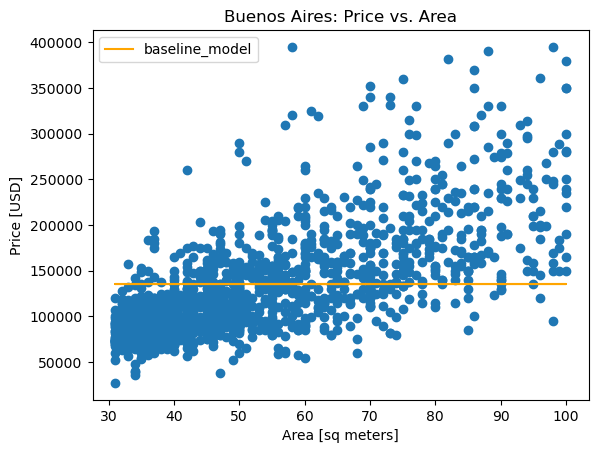

In [27]:
plt.plot(X_train.values, y_prediction_baseline, color='orange', label='baseline_model')
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area")
plt.legend();

In [29]:
# calculating the mean absolute error for the predictions in y_prediction_baseline
mean_abs_error_baseline = mean_absolute_error(y_train, y_prediction_baseline)
mean_abs_error_baseline

print("Mean apartment price:", round(y_mean, 2))
print("Baseline MAE:", round(mean_abs_error_baseline, 2))

Mean apartment price 135527.84
Baseline MAE: 45199.46


In [30]:
# Iterating the model using a liner regression
model = LinearRegression()

# fitting the feature and target into the model
model.fit(X_train, y_train)


LinearRegression()

In [35]:
# eveluating the model
y_prediction_training = model.predict(X_train)
y_prediction_training[:7]

array([169151.87330223, 106064.44707446, 133101.91545779, 106064.44707446,
       124089.42599668, 178164.36276334,  83533.22342168])

In [36]:
# finding the mean absolute error for the prediction training 
mean_abs_error_pred_training = mean_absolute_error(y_train, y_prediction_training)
mean_abs_error_pred_training

print("Prediction Training MAE:", round(mean_abs_error_pred_training, 2))

Prediction Training MAE: 31248.26


In [ ]:
# the mean absolute error reduces by about 10,000 so we can use the model now



In [41]:
# testing the model with some new features it hasnt been introduced to
df_new = pd.read_csv("data/buenos-aires-test-features.csv", encoding='latin-1')
X_test = df_new[feature]

y_pred_test = pd.Series(model.predict(X_test))
y_pred_test

0       117330.058901
1       135355.037823
2        88039.468152
3        88039.468152
4       106064.447074
            ...      
1481     94798.835248
1482    180417.485129
1483    146620.649649
1484    110570.691805
1485    121836.303631
Length: 1486, dtype: float64

In [47]:
# getting the intercept and coefficient of the model
intercept = model.intercept_
print("Model Intercept:", intercept) 

coefficient = model.coef_[0]
print('Model coefficient for "surface_covered_in_m2":', coefficient)

Model Intercept: 11433.307732797795
Model coefficient for "surface_covered_in_m2": 2253.1223652775866


In [48]:
# establishing appartment price formula

print(f'apartment_price = {11433.307732797795} + {2253.1223652775866} * surface_covered')

apartment_price = 11433.307732797795 + 2253.1223652775866 * surface_covered


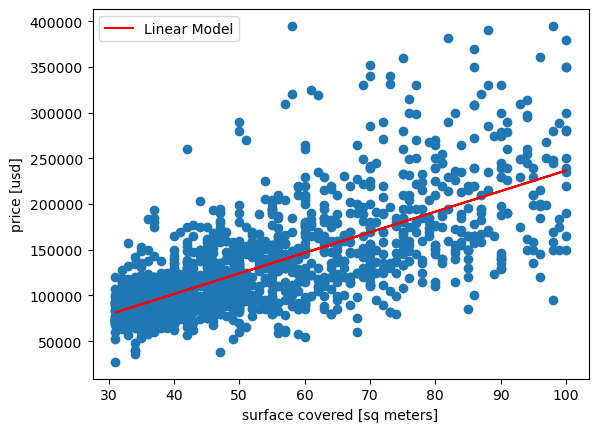

In [51]:
# plotting the model values on a scatter plot
plt.plot(X_train.values, y_prediction_training, color="red", label="Linear Model")
plt.scatter(X_train, y_train)
plt.xlabel("surface covered [sq meters]")
plt.ylabel("price [usd]")
plt.legend();